In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import string
import os
import glob
from PIL import Image
from time import time
from tensorflow.python import keras
import tensorflow as tf
from keras import Input, layers
from keras import optimizers
#from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.optimizer_v2 import adam
from keras_preprocessing import sequence
from keras_preprocessing import image
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout, Bidirectional
#from tensorflow.keras.layers.wrappers import Bidirectional
from keras.layers.merging import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.efficientnet_v2 import EfficientNetV2L
from keras.applications.efficientnet_v2 import preprocess_input
from keras.models import Model
#from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.utils.np_utils import to_categorical
tf.config.set_visible_devices([], 'GPU')

## model for feature extract

In [2]:
import keras as kr
model_EfficientNetV2L = EfficientNetV2L(
    include_top=True,
    weights="imagenet",
    pooling='avg',
    classifier_activation="softmax",
)


In [3]:
model_efficientnet_v2 = Model(model_EfficientNetV2L.input, model_EfficientNetV2L.layers[-2].output)

In [4]:
from keras.models import load_model
caption_model_v1 = load_model('EfficientNetV2L_lstm_model.h5')

In [5]:
max_length = 74
vocab = open('./vocab.txt', 'r').read().strip().split('\n')

ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [6]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(480, 480))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [7]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_efficientnet_v2.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec


In [8]:
def greedySearch_v1(photo, model):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        # print(sequence)
        sequence = pad_sequences([sequence], maxlen=max_length)
        sequence = np.array(sequence)
        # print(sequence)
        yhat = model.predict([photo,sequence], verbose=0) #here we must pass the encoded image otw error show failed to find data adapter
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final


In [9]:
def beam_search_predictions_v1(image, model, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image, par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [10]:
image_name = os.listdir(r"../testingImage/")
image_path = '../testingImage/'

In [11]:
def explain(image_path):
    img = preprocess(image_path)
    pre_img = plt.imshow(img[0])
    plt.savefig('image4.jpg')
    img = tf.convert_to_tensor(img)
    with tf.GradientTape() as tape:
      tape.watch(img)
      feature_vector = model_efficientnet_v2(img)
      # get loss as dot product of feature vector
      loss = tf.math.reduce_sum(feature_vector*feature_vector)
      # get gradient

    gradient = tape.gradient(loss, img)[0]
    alpha = gradient
    gradient = tf.math.reduce_mean(tf.math.abs(gradient), axis=-1)

    # plot
    saliency_img = plt.imshow(gradient, cmap='jet')

    # save the image to disk
    plt.savefig('image2.jpg')


    # get absolute values of alpha
    alpha = tf.math.abs(alpha) 
    # scale alpha to [0, 1]
    alpha = alpha / tf.math.reduce_max(alpha)

    # all values below threshold are set to 0 and all values above are set to 1

    alpha = tf.where(alpha >= 0.05, 1.0, 0.0)
    img = tf.reshape(img, (480, 480, 3))

    new_img2 = img + tf.random.uniform(img.shape, minval = 50, maxval = 70)*alpha

    # conevrt this to ndarray of shape (1, 480, 480, 3) and float32
    new_img2 = tf.reshape(new_img2, (1, 480, 480, 3))
    new_img2 = np.array(new_img2)
    new_img2 = new_img2.astype('float32')
    # plot
    ace_img = plt.imshow(new_img2[0])

    # save the image to disk
    plt.savefig('image3.jpg')

    fea_vec = model_efficientnet_v2.predict(new_img2) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    fea_vec = fea_vec.reshape(1, 1280)
    acap2 = beam_search_predictions_v1(fea_vec, caption_model_v1)
    acap1 = greedySearch_v1(fea_vec, caption_model_v1)
    img = preprocess(image_path)
    plt.imshow(img[0])

    model = model_efficientnet_v2

    last_conv_layer_name = "block7g_add"

    grad_model = tf.keras.models.Model(
      [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]


    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    plt.imshow(heatmap)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img_1 = (-1)*jet_heatmap * 0.4 + img
    superimposed_img_1=plt.imshow(superimposed_img_1[0])
    # save the image to disk
    plt.savefig('image1.jpg')
    plt.show()

    superimposed_img_2 = jet_heatmap * 0.4 + img
    superimposed_img_2 = image.array_to_img(superimposed_img_2[0])
    superimposed_img_2= plt.imshow(superimposed_img_2)
    return superimposed_img_1, acap1, acap2, saliency_img, ace_img, pre_img

1/1 [==============================] - 16s 16s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


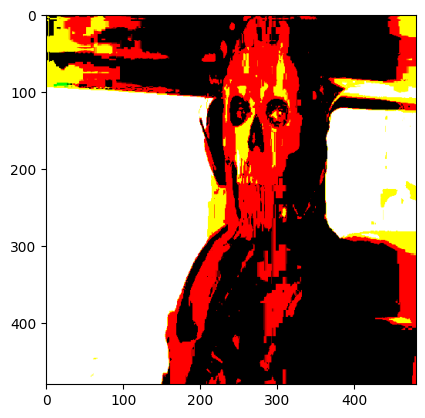

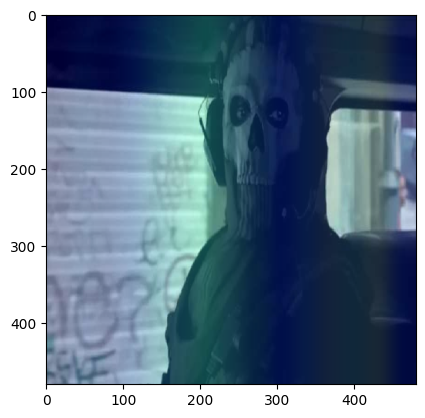

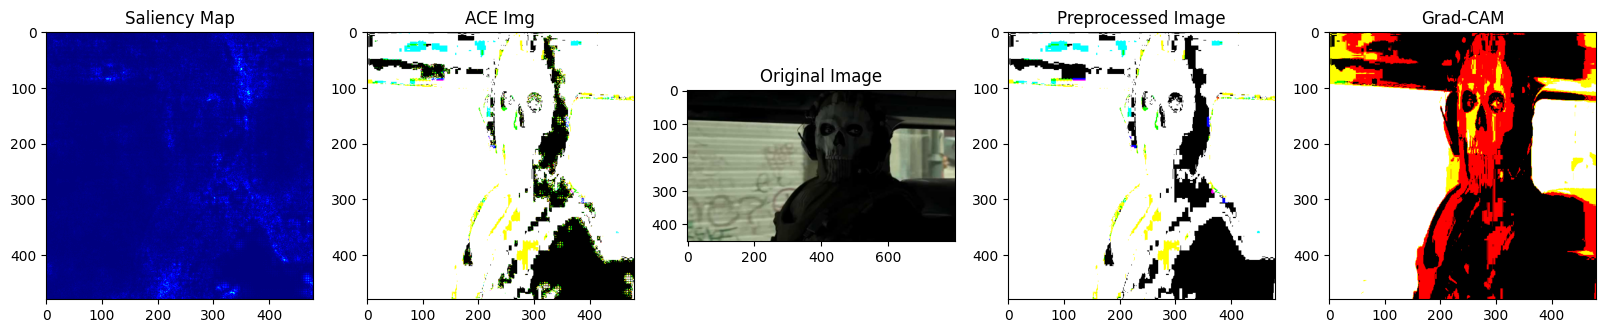

Prediction from model_v1 ::
Greedy Search:======> a man in a white shirt is standing in front of a car a man in a white shirt and black pants is standing in front of a silver car
explanation:==> a man in a black shirt is standing in front of a car with a white arrow a man in a white shirt is standing in front of a graffiti covered wall with graffiti on it
1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


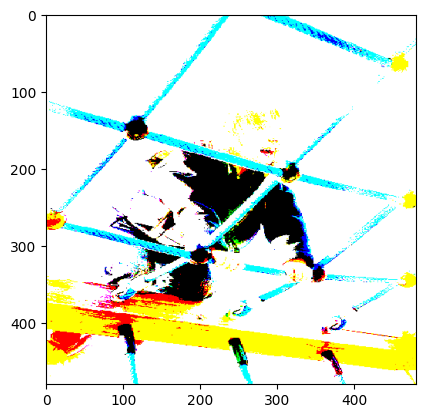

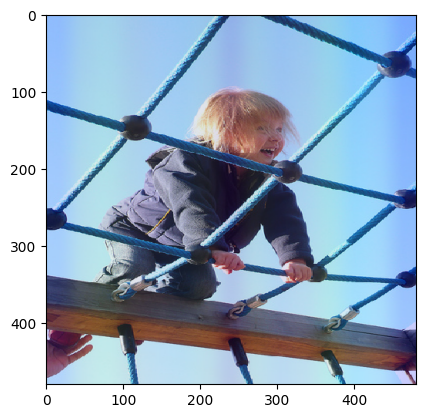

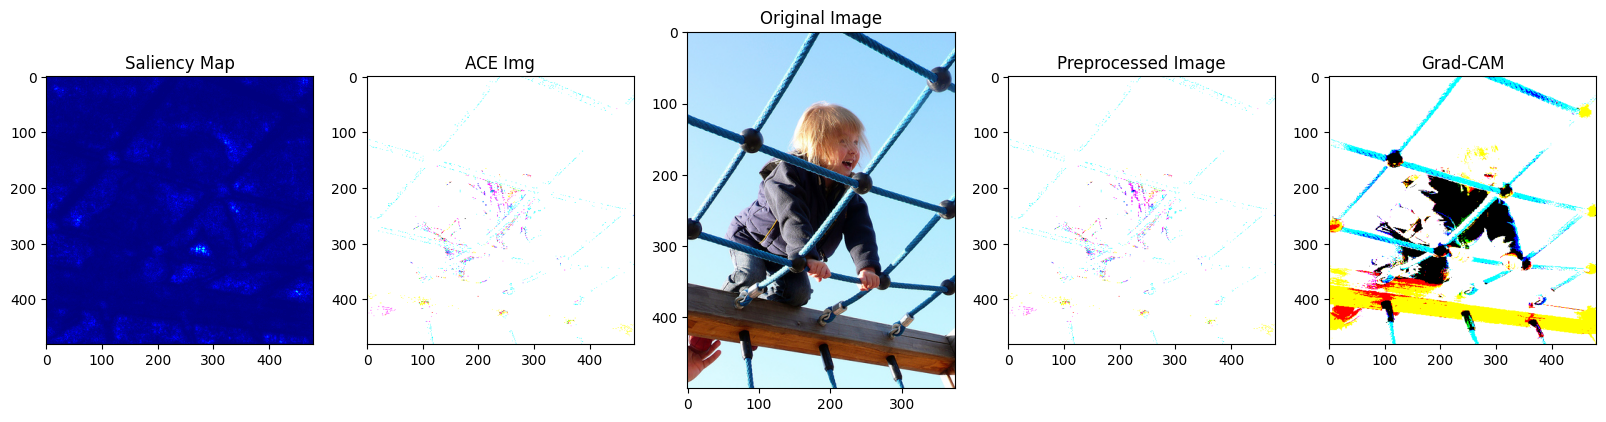

Prediction from model_v1 ::
Greedy Search:======> a young girl is swinging on a swing a little girl in a pink shirt is playing on a swing set
explanation:==> a young girl is swinging on a swing set a little girl in a pink shirt is playing on a swing set
1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


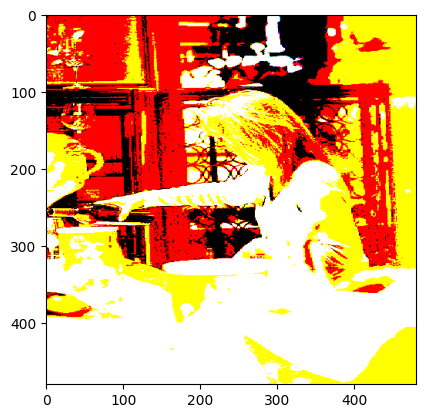

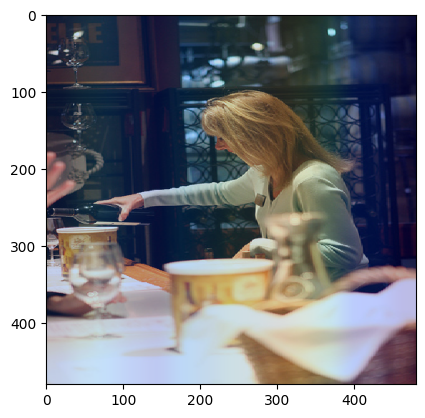

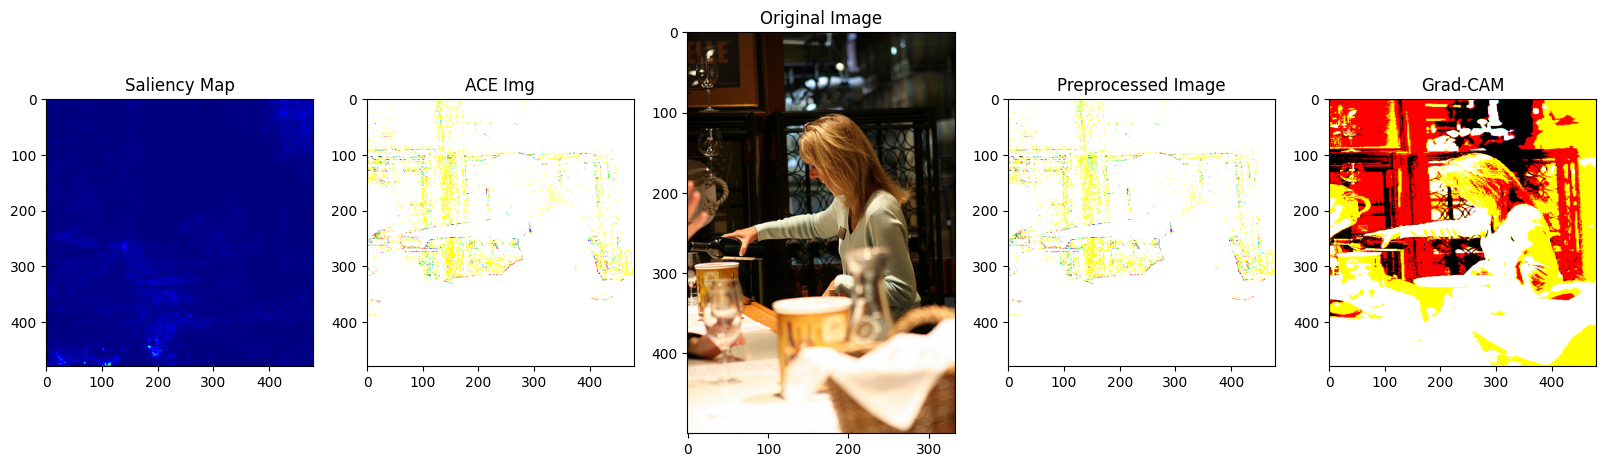

Prediction from model_v1 ::
Greedy Search:======> a man in a white shirt is sitting at a table with a glass of wine a man in a white shirt is sitting at a table in a restaurant
explanation:==> a woman in a white shirt is sitting at a table with a glass of wine a man in a white shirt is sitting at a table in a restaurant
1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


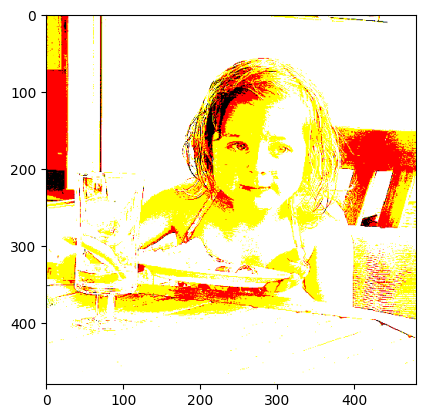

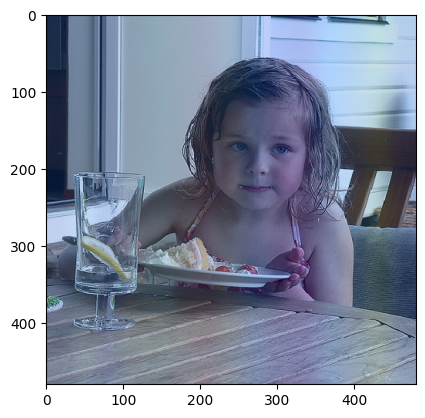

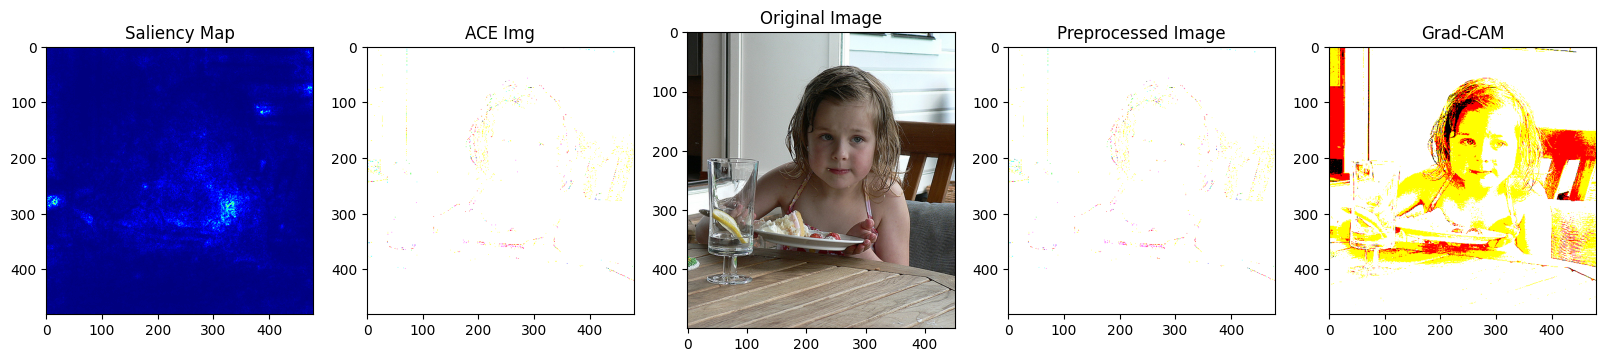

Prediction from model_v1 ::
Greedy Search:======> a young girl in a pink shirt is eating a sandwich a little girl is eating a slice of cake on a deck
explanation:==> a young girl is eating a sandwich in a highchair a little girl in a pink shirt is eating a sandwich


In [12]:
for oneimg in image_name:
    full_img_path = image_path + str(oneimg)
    encoded_img1 = encode( full_img_path )
    grad_cam, a_cap1, a_cap2, saliency_img, ace_img, pre_img = explain(full_img_path)
    encoded_img1 = encoded_img1.reshape(1,1280)

    x = plt.imread(full_img_path) 

    # plot both saliency and ace images and make it bigger
    fig, axs = plt.subplots(1, 5, figsize=(20, 20))

    # Display each imshow object in a separate subplot
    axs[0].imshow(saliency_img.get_array(), cmap='jet')
    axs[1].imshow(ace_img.get_array())
    axs[2].imshow(x)
    axs[3].imshow(pre_img.get_array())
    axs[4].imshow(grad_cam.get_array())
    axs[0].set_title('Saliency Map')

    axs[1].set_title('ACE Img')
    axs[2].set_title('Original Image')
    axs[3].set_title('Preprocessed Image')
    axs[4].set_title('Grad-CAM')
    plt.show()

    print("Prediction from model_v1 ::")
    print("Greedy Search:======>",greedySearch_v1(encoded_img1,caption_model_v1), beam_search_predictions_v1(encoded_img1,caption_model_v1))
    print("explanation:==>",a_cap1, a_cap2)
    

In [15]:
tf.keras.utils.plot_model(caption_model_v1, to_file="my_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
